# パーセプトロン

![](slides/15.png)

<hr>

以下は<a href="https://book.impress.co.jp/books/1120101017">Python機械学習プログラミング</a>に記載のソースコード
- https://github.com/rasbt/python-machine-learning-book-3rd-edition
から取得
- plt.scatter() の edgecolor='black' で warning が出るようになったため、rcParams を使用するように変更
- 学習の途中経過を表示するように改変
  - 初期化後の重み、分類の領域
  - 誤分類発生時の更新差分 ⊿ , 分類の領域

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

mpl.rcParams["scatter.edgecolors"] = 'black'

class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        # 初期化終了後
        # - 重み
        # - 分類の領域を描画
        print('Initialized:')
        print(' w={}'.format(self.w_))
        plot_decision_regions(X, y, self)

        for i in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                # 各データについて以下を表示
                # epoch: η(y-y^)、正解クラス、予測クラス
                print('{}: {} {} {}'.format(i, update, target, self.predict(xi)))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
                # 誤分類が発生（updateが0ではない）した時に表示
                # - 学習率 η , 重みの更新差分 ⊿ , X
                # - 分類の領域を描画
                if update != 0.0:
                    print('Updated: ')
                    print(' delta={} {}, xi={}'.format(update, update * xi, xi))
                    print(' w={}'.format(self.w_))
                    plot_decision_regions(X, y, self)
            self.errors_.append(errors)
            # 各繰り返し (epoch) 後に誤分類回数を表示
            print('Iteration:{}, Erros: {}'.format(i, errors))
            #do_plot(self.w_)
            #plot_decision_regions(X, y, self)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    #x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #x1_min, x1_max = -10, 10
    x2_min, x2_max = -10, 10
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl)
    plt.legend(loc='upper left')
    plt.show()

### Irisデータセット

経過がわかりやすいように、setosa, versicolor それぞれ3つのみにして学習。

In [2]:
import pandas as pd
import seaborn as sns

iris = sns.load_dataset('iris')
iris = iris.query('species != "virginica"')

# それぞれ先頭3つを取り出し、結合
df = pd.concat([iris.query('species == "setosa"').head(3),
                iris.query('species != "setosa"').head(3)])
# 確認
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor


In [3]:
X = df[['sepal_length', 'petal_length']]
Y = df['species'].map(lambda x: 1 if x == 'versicolor' else 0)
# 確認
pd.concat([X, Y], axis=1)

,sepal_length,petal_length,species
0,5.1,1.4,0
1,4.9,1.4,0
2,4.7,1.3,0
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1


### パーセプトロンの学習

改変した Perceptron により学習経過を表示。

- Initialized: 初期値の重み w=[w0, w1, w2]
  - デフォルト値 random_state=1 で同じ乱数を生成
- epoch: η(y-y^) 正解クラス 予測クラス<br>
  正しい分類：
  ```
  0: 0.0 0 0
  0: 0.0 1 1
  ```
  誤分類：
  ```
  0: 0.1 1 0
  1: -0.1 0 1
  ```
- Updated: 誤分類が発生し重みを更新
  - delta=学習率 η , [重みの更新差分 ⊿], [x1, x2]
  - 更新後の重み w=[w0, w1, w2]
  - 分類の領域を描画

Initialized:
 w=[ 0.01624345 -0.00611756 -0.00528172]


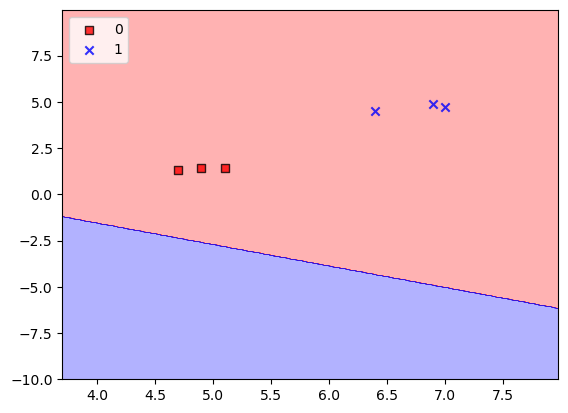

0: 0.0 0 0
0: 0.0 0 0
0: 0.0 0 0
0: 0.1 1 0
Updated: 
 delta=0.1 [0.7  0.47], xi=[7.  4.7]
 w=[0.11624345 0.69388244 0.46471828]


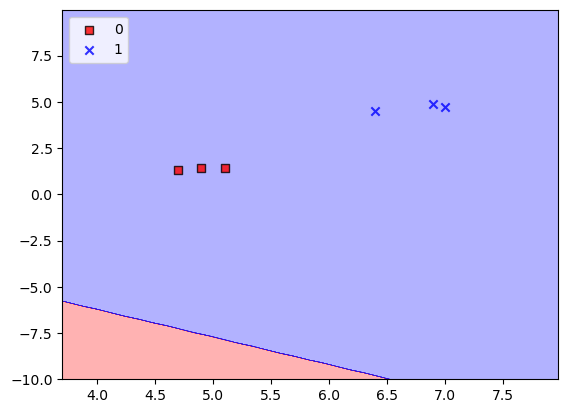

0: 0.0 1 1
0: 0.0 1 1
Iteration:0, Erros: 1
1: -0.1 0 1
Updated: 
 delta=-0.1 [-0.51 -0.14], xi=[5.1 1.4]
 w=[0.01624345 0.18388244 0.32471828]


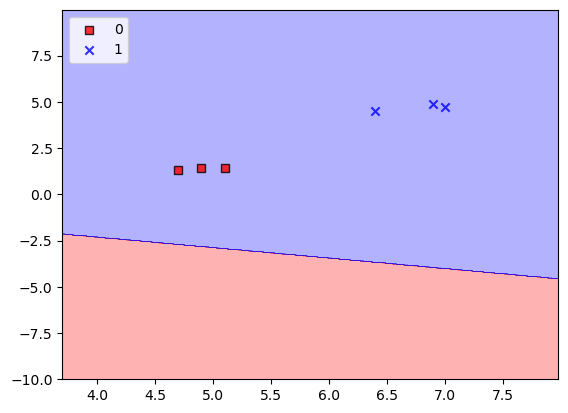

1: -0.1 0 1
Updated: 
 delta=-0.1 [-0.49 -0.14], xi=[4.9 1.4]
 w=[-0.08375655 -0.30611756  0.18471828]


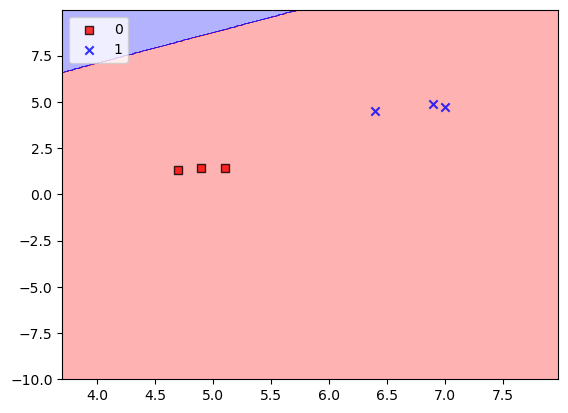

1: 0.0 0 0
1: 0.1 1 0
Updated: 
 delta=0.1 [0.7  0.47], xi=[7.  4.7]
 w=[0.01624345 0.39388244 0.65471828]


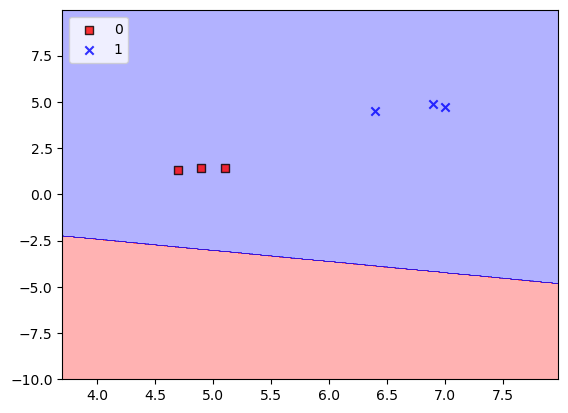

1: 0.0 1 1
1: 0.0 1 1
Iteration:1, Erros: 3
2: -0.1 0 1
Updated: 
 delta=-0.1 [-0.51 -0.14], xi=[5.1 1.4]
 w=[-0.08375655 -0.11611756  0.51471828]


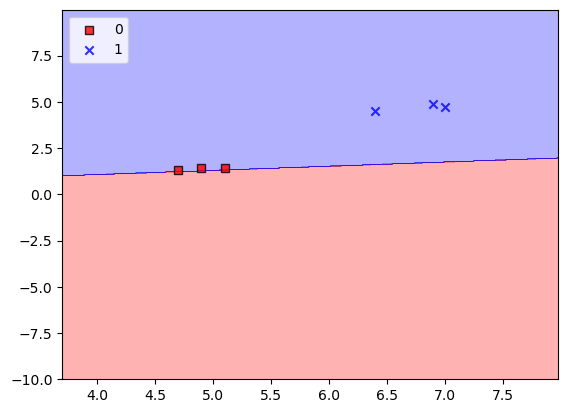

2: -0.1 0 1
Updated: 
 delta=-0.1 [-0.49 -0.14], xi=[4.9 1.4]
 w=[-0.18375655 -0.60611756  0.37471828]


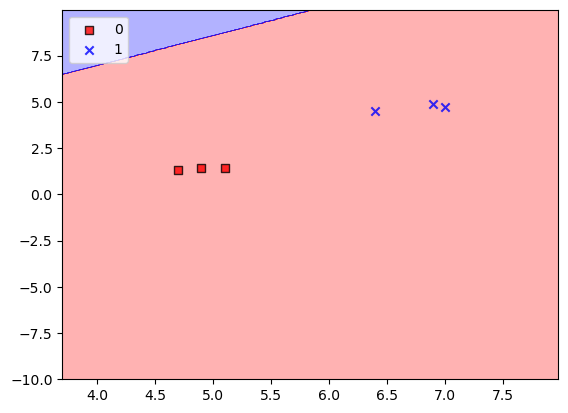

2: 0.0 0 0
2: 0.1 1 0
Updated: 
 delta=0.1 [0.7  0.47], xi=[7.  4.7]
 w=[-0.08375655  0.09388244  0.84471828]


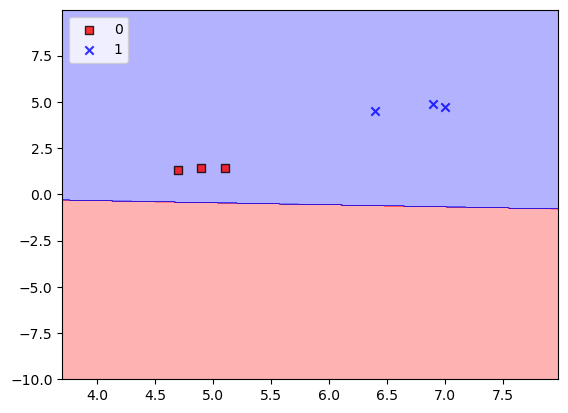

2: 0.0 1 1
2: 0.0 1 1
Iteration:2, Erros: 3
3: -0.1 0 1
Updated: 
 delta=-0.1 [-0.51 -0.14], xi=[5.1 1.4]
 w=[-0.18375655 -0.41611756  0.70471828]


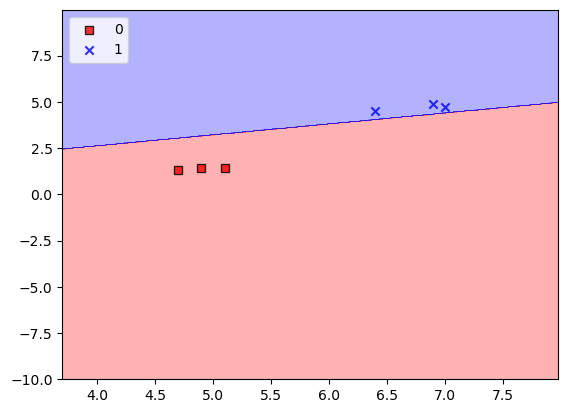

3: 0.0 0 0
3: 0.0 0 0
3: 0.0 1 1
3: 0.0 1 1
3: 0.0 1 1
Iteration:3, Erros: 1
4: 0.0 0 0
4: 0.0 0 0
4: 0.0 0 0
4: 0.0 1 1
4: 0.0 1 1
4: 0.0 1 1
Iteration:4, Erros: 0
5: 0.0 0 0
5: 0.0 0 0
5: 0.0 0 0
5: 0.0 1 1
5: 0.0 1 1
5: 0.0 1 1
Iteration:5, Erros: 0
6: 0.0 0 0
6: 0.0 0 0
6: 0.0 0 0
6: 0.0 1 1
6: 0.0 1 1
6: 0.0 1 1
Iteration:6, Erros: 0
7: 0.0 0 0
7: 0.0 0 0
7: 0.0 0 0
7: 0.0 1 1
7: 0.0 1 1
7: 0.0 1 1
Iteration:7, Erros: 0
8: 0.0 0 0
8: 0.0 0 0
8: 0.0 0 0
8: 0.0 1 1
8: 0.0 1 1
8: 0.0 1 1
Iteration:8, Erros: 0
9: 0.0 0 0
9: 0.0 0 0
9: 0.0 0 0
9: 0.0 1 1
9: 0.0 1 1
9: 0.0 1 1
Iteration:9, Erros: 0


In [4]:
model = Perceptron(eta=0.1, n_iter=10)
# - random_state を変更すると初期値が変わり、結果も変わる
#model = Perceptron(eta=0.1, n_iter=10, random_state=10)
# 学習
model.fit(X.values, Y.values)

### 各繰り返し (epoch) での誤分類の個数

Text(0, 0.5, 'Number of updates')

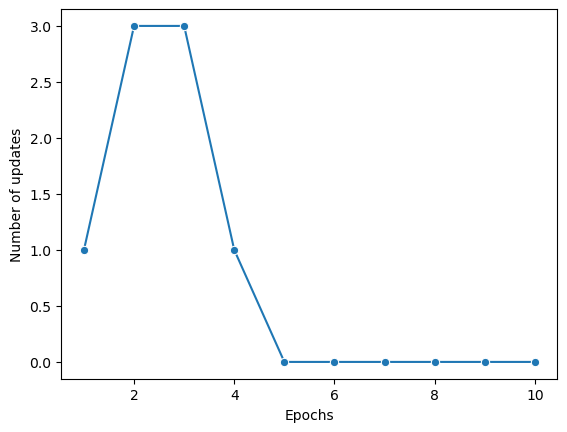

In [5]:
sns.lineplot(x=range(1, len(model.errors_) + 1), y=model.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

### 学習後のモデルから計算される境界

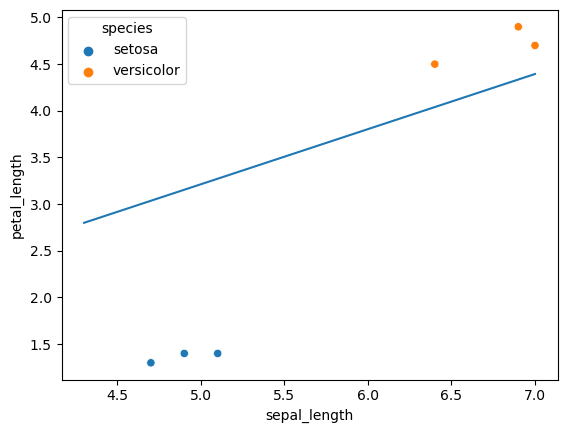

In [6]:
sns.scatterplot(data=df, x='sepal_length', y='petal_length', hue='species')
#
_min = iris.sepal_length.min()
_max = iris.sepal_length.max()
_step = (_max - _min) / 100
_X = np.arange(_min, _max + _step, _step)
plt.plot(_X, (- model.w_[0] - model.w_[1] * _X) / model.w_[2])